In [1]:
%pip install alpha_vantage
%pip install arch


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
from pair_trading_foundations.utils import GetSP500Data
from arch.unitroot import engle_granger, ADF
from alpha_vantage.timeseries import TimeSeries
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()
import pandas as pd
import numpy as np
import warnings
# The yfinance module has some deprecation warning
warnings.filterwarnings('ignore')

/Users/michaeltay/miniforge3/lib/python3.9/site-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


[*********************100%%**********************]  3 of 3 completed

Price       Adj Close                             Close             \
Ticker           AAPL      GOOGL        MSFT       AAPL      GOOGL   
Date                                                                 
2018-12-03  44.291550  55.818001  106.440346  46.205002  55.818001   
2018-12-04  42.343212  53.123501  103.050262  44.172501  53.123501   
2018-12-06  41.871105  53.903999  103.686531  43.680000  53.903999   
2018-12-07  40.378113  52.328999   99.536766  42.122501  52.328999   
2018-12-10  40.644115  52.659000  102.167160  42.400002  52.659000   

Price                        High                               Low  \
Ticker            MSFT       AAPL      GOOGL        MSFT       AAPL   
Date                                                                  
2018-12-03  112.089996  46.235001  56.750000  113.419998  45.302502   
2018-12-04  108.519997  45.597500  55.712002  112.639999  44.067501   
2018-12-06  109.190002  43.695000  53.971001  109.239998  42.605000   
2018-12-07  1

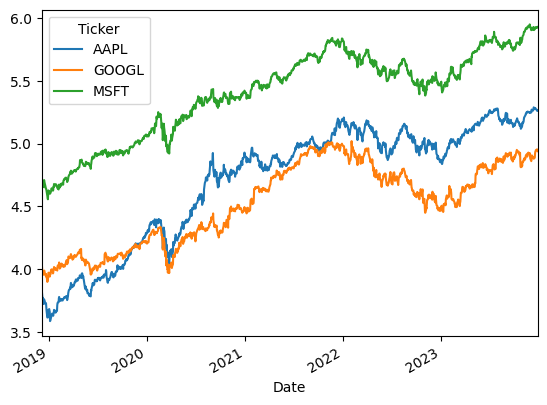

In [3]:
def get_sp500_symbols():
    sp500_symbols = ['AAPL', 'MSFT', 'GOOGL']  # Have feed list of S&P 500 component symbols
    return sp500_symbols

if __name__ == '__main__':
    # get all stock info interested
    data_frame = pdr.get_data_yahoo(get_sp500_symbols(), start='2018-12-01', end='2023-12-31')
    
    print(data_frame.head())

    # Filter by open prices
    log_price = np.log(data_frame['Open'])
    ax = log_price.plot()
    xl = ax.set_xlim(log_price.index.min(), log_price.index.max())

In [4]:
# Dicker-fuller test for APPL, fail to reject the null hypothesis p-value > 0.05
ADF(log_price.AAPL, trend="c")

Test Statistic,-1.578
P-value,0.495
Lags,3


In [5]:
# Dicker-fuller test for diff(1,APPL), reject the null hypothesis p-value < 0.05, trend is stationary
ADF(log_price.AAPL.diff(periods=1).dropna(), trend="c")

Test Statistic,-22.716
P-value,0.000
Lags,2


In [6]:
# Dicker-fuller test for GOOGL, fail to reject the null hypothesis p-value > 0.05
ADF(log_price.GOOGL, trend="c")

Test Statistic,-1.210
P-value,0.669
Lags,1


In [7]:
# Dicker-fuller test for diff(1,GOOGL), reject the null hypothesis p-value < 0.05, trend is stationary
ADF(log_price.GOOGL.diff(periods=1).dropna(), trend="c")

Test Statistic,-37.760
P-value,0.000
Lags,0


In [8]:
# Dicker-fuller test for MSFT, fail to reject the null hypothesis p-value > 0.05
ADF(log_price.MSFT, trend="c")

Test Statistic,-1.377
P-value,0.593
Lags,3


In [9]:
# Dicker-fuller test for diff(1,GOOGL), reject the null hypothesis p-value < 0.05, trend is stationary
ADF(log_price.MSFT.diff(periods=1).dropna(), trend="c")

Test Statistic,-23.318
P-value,0.000
Lags,2


In [10]:
# Michael: APPL & MSFT looks cointegrated, p-value < 0.05, but fail the ADF test
eg_test = engle_granger(log_price.AAPL.diff(periods=1).dropna(), log_price.MSFT.diff(periods=1).dropna(), trend="n")
eg_test

Test Statistic,-37.528
P-value,0.000
ADF Lag length,0
Estimated Root ρ (γ+1),-0.050


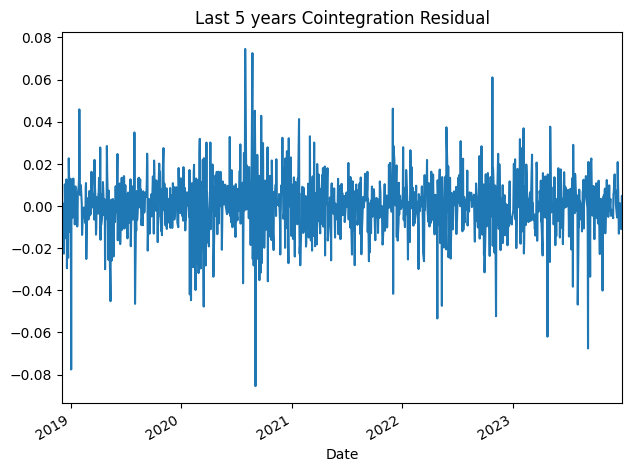

In [11]:
# Michael: Plot the residuals for cointegration 
fig = eg_test.plot()
ax = fig.get_axes()[0]
title = ax.set_title("Last 5 years Cointegration Residual")